# `hmmlearn`

Does not seem to work with `scikit-learn` 0.2.

    conda install -c omnia hmmlearn=0.3.0b=np112py36_0
    conda install -c omnia scikit-learn=0.19.1=py36hedc7406_0

# Diff

http://pcfarina.eng.unipr.it/Differentiation_Integration.htm


# FFT

https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html

# Inverting the FFT

I found that generating data using many frequencies, FFT then inverting the FFT gives unexpected patterns in the data. It should have been obvious, there are regions where it is too synchronised and there is constructive and destructive interference.

I think that I have previously seen a webpage desctibing this and the efforts (windowing and weighting) to compensate. 

I found it easier just to have one peak with some randomness added to the time series and not inverting.

Unless it is generated for the sampling rate, inverting will not work

    np.real(ifft(yr))
    
    
# TODO


# Generate for loads of dat

    def features(acceleration_df
                 , window_accel_samples
                 , feature_function):

        length = len(acceleration_df)
        grouper = np.arange(length, dtype=int)//window_accel_samples

        return acceleration_df.groupby(grouper).apply(feature_function)

In [74]:
import random
import numpy as np
import pandas as pd
from hmmlearn import hmm
import scipy.fftpack#.fft
import matplotlib.pyplot as plt
%matplotlib inline

# GENERATE

# Probabilities too high for 900 samples
n_samples = 900

np.random.seed(42)

# Numer of components, i.e. number of classifications
# 0 ruminating
# 1 eating 
# 2 other
# 3 ruminating while ill
# 4 eating while ill
# 5 other whilt ill
n_components = 6

model = hmm.GaussianHMM(n_components=n_components
                        , covariance_type="full")

# Start probabilities
p_start_rum_wel = 0.6-0.01
p_start_eat_wel = 0.3-0.01
p_start_oth_wel = 0.1-0.01
p_start_rum_ill = 0.01
p_start_eat_ill = 0.01
p_start_oth_ill = 0.01
# p_start_rum_wel = 1.0
# p_start_eat_wel = 0.0
# p_start_oth_wel = 0.0
# p_start_rum_ill = 0.0
# p_start_eat_ill = 0.0
# p_start_oth_ill = 0.0

# Probability delta-in-transition from well to ill
# p_d_wel_to_ill = 0.0 # 0.01
p_d_wel_to_ill = 0.01
p_d_ill_to_well = 0.1

###############################################################################
# Base probability transitions
# Without taking into account 
# wellness and illness
###############################################################################

# Probability of transition from rumination
#p_trans_rum_to_rum = 1.0
#p_trans_rum_to_eat = 0.0
#p_trans_rum_to_oth = 0.0
p_trans_rum_to_rum = 0.7
p_trans_rum_to_eat = 0.2
p_trans_rum_to_oth = 0.1

# Probability of transition from eating
p_trans_eat_to_rum = 0.3
p_trans_eat_to_eat = 0.5
p_trans_eat_to_oth = 0.2

# Probability of transition from other
p_trans_oth_to_rum = 0.3
p_trans_oth_to_eat = 0.3
p_trans_oth_to_oth = 0.4

###############################################################################
# Transition proabiities with sickness and wellness 
###############################################################################

# Prob of transition from rumination
p_trans_rum_wel_to_rum_wel = p_trans_rum_to_rum - p_d_wel_to_ill
p_trans_rum_wel_to_eat_wel = p_trans_rum_to_eat - p_d_wel_to_ill
p_trans_rum_wel_to_oth_wel = p_trans_rum_to_oth - p_d_wel_to_ill
p_trans_rum_wel_to_rum_ill = p_d_wel_to_ill
p_trans_rum_wel_to_eat_ill = p_d_wel_to_ill
p_trans_rum_wel_to_oth_ill = p_d_wel_to_ill

#print(p_trans_rum_wel_to_rum_wel
#    , p_trans_rum_wel_to_eat_wel
#    , p_trans_rum_wel_to_oth_wel
#    , p_trans_rum_wel_to_rum_ill
#    , p_trans_rum_wel_to_eat_ill
#    , p_trans_rum_wel_to_oth_ill)



# Prob of transition from eating
p_trans_eat_wel_to_rum_wel = p_trans_eat_to_rum-p_d_wel_to_ill
p_trans_eat_wel_to_eat_wel = p_trans_eat_to_eat-p_d_wel_to_ill
p_trans_eat_wel_to_oth_wel = p_trans_eat_to_oth-p_d_wel_to_ill
p_trans_eat_wel_to_rum_ill = p_d_wel_to_ill
p_trans_eat_wel_to_eat_ill = p_d_wel_to_ill
p_trans_eat_wel_to_oth_ill = p_d_wel_to_ill

# Prob of transition from other
p_trans_oth_wel_to_rum_wel = p_trans_oth_to_rum-p_d_wel_to_ill
p_trans_oth_wel_to_eat_wel = p_trans_oth_to_eat-p_d_wel_to_ill
p_trans_oth_wel_to_oth_wel = p_trans_oth_to_oth-p_d_wel_to_ill
p_trans_oth_wel_to_rum_ill = p_d_wel_to_ill
p_trans_oth_wel_to_eat_ill = p_d_wel_to_ill
p_trans_oth_wel_to_oth_ill = p_d_wel_to_ill

# SICK
# Prob of transition from rumination sick
p_trans_rum_ill_to_rum_wel = p_d_ill_to_well
p_trans_rum_ill_to_eat_wel = p_d_ill_to_well
p_trans_rum_ill_to_oth_wel = p_d_ill_to_well
p_trans_rum_ill_to_rum_ill = p_trans_rum_to_rum - p_d_ill_to_well
p_trans_rum_ill_to_eat_ill = p_trans_rum_to_eat - p_d_ill_to_well
p_trans_rum_ill_to_oth_ill = p_trans_rum_to_oth - p_d_ill_to_well

# Prob of transition from eating sick
p_trans_eat_ill_to_rum_wel = p_d_ill_to_well
p_trans_eat_ill_to_eat_wel = p_d_ill_to_well
p_trans_eat_ill_to_oth_wel = p_d_ill_to_well
p_trans_eat_ill_to_rum_ill = p_trans_eat_to_rum - p_d_ill_to_well
p_trans_eat_ill_to_eat_ill = p_trans_eat_to_eat - p_d_ill_to_well
p_trans_eat_ill_to_oth_ill = p_trans_eat_to_oth - p_d_ill_to_well

# Prob of transition from other sick
p_trans_oth_ill_to_rum_wel = p_d_ill_to_well
p_trans_oth_ill_to_eat_wel = p_d_ill_to_well
p_trans_oth_ill_to_oth_wel = p_d_ill_to_well
p_trans_oth_ill_to_rum_ill = p_trans_oth_to_rum - p_d_ill_to_well
p_trans_oth_ill_to_eat_ill = p_trans_oth_to_eat - p_d_ill_to_well
p_trans_oth_ill_to_oth_ill = p_trans_oth_to_oth - p_d_ill_to_well

# Setting start probabilities 
model.startprob_ = np.array([p_start_rum_wel
                             , p_start_eat_wel
                             , p_start_oth_wel
                             , p_start_rum_ill
                             , p_start_eat_ill
                             , p_start_oth_ill])

model.transmat_ = np.array([[p_trans_rum_wel_to_rum_wel # 0 to
                             , p_trans_rum_wel_to_eat_wel # 0 to
                             , p_trans_rum_wel_to_oth_wel # 0 to
                             , p_trans_rum_wel_to_rum_ill # 0 to
                             , p_trans_rum_wel_to_eat_ill # 0 to
                             , p_trans_rum_wel_to_oth_ill], # 0 to
                            [p_trans_eat_wel_to_rum_wel # 1
                             , p_trans_eat_wel_to_eat_wel # 1
                             , p_trans_eat_wel_to_oth_wel # 1
                             , p_trans_eat_wel_to_rum_ill # 1
                             , p_trans_eat_wel_to_eat_ill # 1
                             , p_trans_eat_wel_to_oth_ill], # 1
                            [p_trans_oth_wel_to_rum_wel # 2
                             , p_trans_oth_wel_to_eat_wel # 2
                             , p_trans_oth_wel_to_oth_wel # 2
                             , p_trans_oth_wel_to_rum_ill # 2
                             , p_trans_oth_wel_to_eat_ill # 2
                             , p_trans_oth_wel_to_oth_ill], # 2
                            # Ill ruminating to 
                            [p_trans_rum_ill_to_rum_wel # 3
                             , p_trans_rum_ill_to_eat_wel # 3
                             , p_trans_rum_ill_to_oth_wel # 3
                             , p_trans_rum_ill_to_rum_ill # 3
                             , p_trans_rum_ill_to_eat_ill # 3
                             , p_trans_rum_ill_to_oth_ill], # 3
                            # Ill eating to
                            [p_trans_eat_ill_to_rum_wel # 4
                             , p_trans_eat_ill_to_eat_wel # 4
                             , p_trans_eat_ill_to_oth_wel # 4
                             , p_trans_eat_ill_to_rum_ill # 4
                             , p_trans_eat_ill_to_eat_ill # 4
                             , p_trans_eat_ill_to_oth_ill], # 4
                            # 5 Ill other to 
                            [p_trans_oth_ill_to_rum_wel # 5 
                             , p_trans_oth_ill_to_eat_wel # 5
                             , p_trans_oth_ill_to_oth_wel # 5
                             , p_trans_oth_ill_to_rum_ill # 5
                             , p_trans_oth_ill_to_eat_ill # 5
                             , p_trans_oth_ill_to_oth_ill] # 5
                           ])



###############################################################################
# EMMISSIONS
###############################################################################

# cols
# 1. frequency peak location - about 2.5
# 2. frequency peak magnitude - value to be investigated
# 3. variance of noise magnitude - zero

# TODO: when not in rumination, does it's magnitude drop or does it just become
# a messier signal. Possibly, messier as the noise it fixed.
# This is, unless the variance noise variance is being used as a eating proxi

# Still not decided if eating is messed up peak frequency or added variance

# As a starting point
# Frequency for ruination 
# Eating variance
# Other low variance and low frequency

# Hmmm there is always a return, of some sort. Only animal moving is linear

# model.covars_ = np.tile(np.identity(3), (n_components, 1, 1))

# TODO: INteresting... Increasing the variance of the peak locations, ends up
# making the signal a mess. Is it possible that increaing the variance in the 
# frequency can replace the variance or/and frequency peakmagnitude variance.
# 
# What is one peak random is the same a random signal.
#
# If not the above then I think that we may nonnt need a variance in the 
# frequency magnitude (2) and the noise vaue (3). However, as the noise is 
# real maybe it is easier to characterise this on its own. It is possile that
# the characterisation of the apmplitude noise might be a function of the amplitude
# and is easier to handle separately.
#
###############################################################################
# Emission covariances 
###############################################################################
#
# 1. Frequency peak location variance. This has to be samll or the signal is 
#  lost.
# 2. Frequency peak magnitude variance. Value to be investigated.
# 3. Variance magnitude. This output value is used directly as the noise. Value
#  still to be investigated
# 
#
# [[1 - -]
#  [- 2 -]
#  [- - 3]]
#
#
# Mean frequency peak Hz
peak_frequency_mean_hz = 2.5
# Mean frequency magnitude 
peak_frequency_mean_magnitude = 1.0
# Mean noise magnitude mean
noise_mean = 0.0

emission_frequency_peak_variance = 0.0001
emission_frequency_peak_magnitude_variance = 0.10
emission_noise_variance = 0.1

model.means_ = np.array([
      [peak_frequency_mean_hz, peak_frequency_mean_magnitude, noise_mean]    # 0 - rum 
    , [peak_frequency_mean_hz, peak_frequency_mean_magnitude, noise_mean]    # 1 - eat
    , [peak_frequency_mean_hz, peak_frequency_mean_magnitude, noise_mean]    # 2 - oth
    , [peak_frequency_mean_hz, peak_frequency_mean_magnitude, noise_mean]    # 3 - rum ill
    , [peak_frequency_mean_hz, peak_frequency_mean_magnitude, noise_mean]    # 4 - eat ill
    , [peak_frequency_mean_hz, peak_frequency_mean_magnitude, noise_mean]    # 5 - oth ill
])

# No covarience assumed
covarance_matrix = [
     [emission_frequency_peak_variance, 0., 0.],
     [0., emission_frequency_peak_magnitude_variance, 0.],
     [0., 0., emission_noise_variance]]

#covarance_matrix_eat = [
#     [emission_frequency_peak_variance * 1.0/10000.0, 0., 0.],
#     [0., emission_frequency_peak_magnitude_variance, 0.],
#     [0., 0., emission_noise_variance]]

model.covars_ = np.array([    
       # Covariances of the outputs when the cow is ruminating
       covarance_matrix

       # Covariances of the outputs when the cow is eating     
       , covarance_matrix

       # Covariances of the outputs when the cow is other
       , covarance_matrix
    
       # Covariances of the outputs when the cow is ruminating ill
       , covarance_matrix
    
       # Covariances of the outputs when the cow is eating ill
       , covarance_matrix
    
       # Covariances of the outputs when the cow is other ill
       , covarance_matrix])

X, Z = model.sample(n_samples)

features_for_generating_data = pd.DataFrame(
    X
    , columns=['f_peak', 'f_magnitude', 'variance'])

###############################################################################
# FFT
###############################################################################

# Sampling rate and time vector
# seconds
start_time = 0 
# seconds
end_time = 90
# Hz
sampling_rate = 10 
# array size
N = (end_time - start_time)*sampling_rate 

time = np.linspace(start_time, end_time, N)

features_for_generating_data['time'] = time

features_for_generating_data['signal'] = (features_for_generating_data['f_magnitude']
                      * np.sin(
                          2 * np.pi
                          * features_for_generating_data['f_peak']
                          * features_for_generating_data['time'])
                      #+ np.sin(2*pi*2.5*features['time'])
                      #+ np.sin(2*np.pi*1.8*features_for_generating_data['time'])
                      + features_for_generating_data['variance']
                     )


yr = scipy.fftpack.fft(features_for_generating_data['signal']) # "raw" FFT with both + and - frequencies
y = 2/N * np.abs(yr[0:np.int(N/2)]) # positive freqs only

# Nyquist Sampling Criteria
T = 1/sampling_rate # inverse of the sampling rate
x = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

# FFT algorithm
#vib_data = features_for_generating_data['signal']
#yr = fft(vib_data) # "raw" FFT with both + and - frequencies
#y = 2/N * np.abs(yr[0:np.int(N/2)]) # positive freqs only

#features_for_generating_data['signal'][0:100].plot()

# Plotting the results
# plt.plot(x, y)
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Vibration (g)')
# plt.title('Frequency Domain (Healthy Machinery)');


# Don't forget about doing the diff

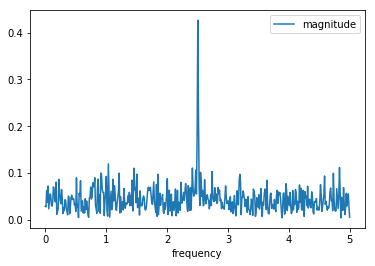

In [72]:
pd.DataFrame({'frequency':x, 'magnitude':y}).plot(x='frequency', y='magnitude')


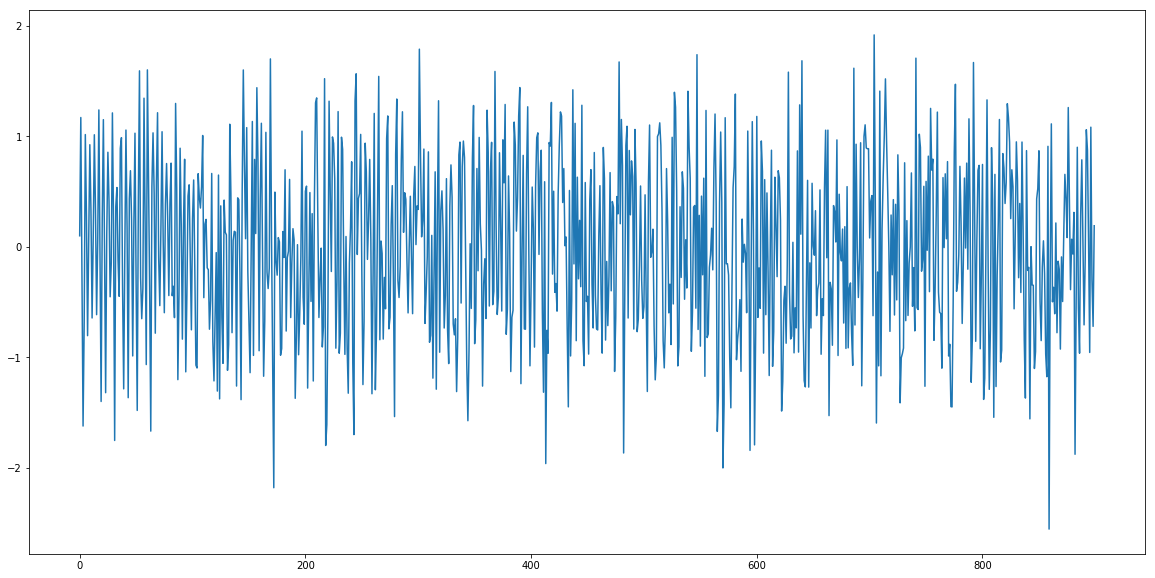

In [73]:
features_for_generating_data['signal'].plot(figsize=(20,10))

In [60]:
features_for_generating_data.plot??

In [ ]:
features_for_generating_data['signal'].plot

In [48]:
features_for_generating_data

,f_peak,f_magnitude,variance,time,signal
0,2.503189,-0.572436,8.824060e-06,0.000000,0.000009
1,2.495305,2.429084,1.715726e-05,0.100111,2.429100
2,2.490759,0.191946,-8.261605e-05,0.200222,0.001478
3,2.489872,2.344026,9.937373e-06,0.300334,-2.343790
4,2.478604,0.005322,-1.990575e-05,0.400445,-0.000269
5,2.494556,1.845304,3.507680e-06,0.500556,1.845243
6,2.509474,0.151113,9.203303e-06,0.600667,-0.006976
7,2.499865,0.101183,-3.344776e-05,0.700779,-0.101209
8,2.503893,0.675508,-4.000658e-05,0.800890,0.022633
9,2.486718,2.544310,6.225299e-06,0.901001,2.539819


# Variance 0.1

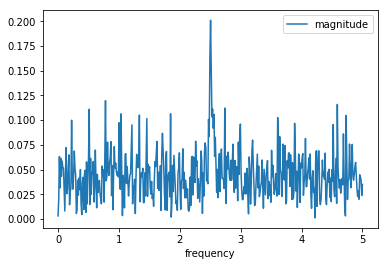

In [19]:
pd.DataFrame({'frequency':x, 'magnitude':y}).plot(x='frequency', y='magnitude')

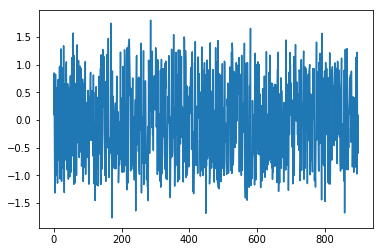

In [16]:
features_for_generating_data['signal'].plot()